# CNN Model & Training
**Author:** Sandy Tam
<br>

**Dataset:** Kaggle - Cat Breeds Dataset

This notebook documents the definition and training of my CNN model.  

#### Import libraries

In [ ]:
import os
import gc
import time 
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print("Using device:", device)

# -------- UNCOMMENT IF USING GPU --------
# from torch.amp import autocast, GradScaler
# torch.cuda.empty_cache()
# gc.collect()

# torch.backends.cudnn.benchmark = True

Using device: cpu


#### Implement checkpoint system

In [2]:
def save_checkpoint(model, optimizer, scheduler, epoch, history, kernel_size, 
                   checkpoint_dir='checkpoints', is_best=False):
    """Save training checkpoint."""
    os.makedirs(checkpoint_dir, exist_ok=True)
    torch.cuda.empty_cache()
    
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
        'history': history,
        'kernel_size': kernel_size,
        'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        'gpu_memory_peak': torch.cuda.max_memory_allocated(0) / 1e9
    }
    
    checkpoint_path = os.path.join(checkpoint_dir, f'k{kernel_size}_epoch{epoch}.pt')
    torch.save(checkpoint, checkpoint_path)
    print(f"Saved: {checkpoint_path}")
    
    if is_best:
        best_path = os.path.join(checkpoint_dir, f'best.pt')
        torch.save(checkpoint, best_path)
        print(f"Best model saved!")
    
    latest_path = os.path.join(checkpoint_dir, f'latest.pt')
    torch.save(checkpoint, latest_path)
    
    return checkpoint_path


def load_checkpoint(checkpoint_path, model, optimizer=None, scheduler=None, device='cuda'):
    """Load checkpoint and resume training."""
    if not os.path.exists(checkpoint_path):
        return 0, {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    print(f"\nLoading checkpoint: {checkpoint_path}")
    checkpoint = torch.load(checkpoint_path, map_location=device)
    
    model.load_state_dict(checkpoint['model_state_dict'])
    if optimizer:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    if scheduler and checkpoint.get('scheduler_state_dict'):
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    
    start_epoch = checkpoint['epoch'] + 1
    history = checkpoint['history']
    
    print(f"Resuming from epoch {start_epoch}")
    if history['val_acc']:
        print(f"  Best val acc so far: {max(history['val_acc']):.2f}%\n")
    
    return start_epoch, history


def find_latest_checkpoint(kernel_size, checkpoint_dir='checkpoints'):
    """Find the most recent checkpoint."""
    latest_path = os.path.join(checkpoint_dir, f'latest.pt')
    return latest_path if os.path.exists(latest_path) else None


def list_checkpoints(checkpoint_dir='checkpoints'):
    """List all checkpoints."""
    if not os.path.exists(checkpoint_dir):
        print("No checkpoints found")
        return
    
    checkpoints = sorted([f for f in os.listdir(checkpoint_dir) if f.endswith('.pt')])
    if not checkpoints:
        print("No checkpoints found")
        return
    
    print(f"\n{'='*70}")
    print(f"Available Checkpoints ({len(checkpoints)} files)")
    print(f"{'='*70}")
    
    for cp in checkpoints:
        cp_path = os.path.join(checkpoint_dir, cp)
        try:
            checkpoint = torch.load(cp_path, map_location='cpu')
            best_val = max(checkpoint['history']['val_acc']) if checkpoint['history']['val_acc'] else 0
            print(f"{cp}: Epoch {checkpoint['epoch']} | Val Acc {best_val:.2f}%")
        except:
            print(f"{cp} (unable to load)")
    print(f"{'='*70}\n")


print("Checkpoint system loaded!")

Checkpoint system loaded!


#### Define CNN class

In [4]:
class CatBreedCNN(nn.Module):
    def __init__(self, num_classes=66, kernel_size=3):
        super(CatBreedCNN, self).__init__()
        
        padding = kernel_size // 2
        
        # Block 1
        self.conv1 = nn.Conv2d(3, 64, kernel_size, padding=padding)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, kernel_size, padding=padding)
        self.bn2 = nn.BatchNorm2d(64)
        
        # Block 2
        self.conv3 = nn.Conv2d(64, 128, kernel_size, padding=padding)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, kernel_size, padding=padding)
        self.bn4 = nn.BatchNorm2d(128)
        
        # Block 3
        self.conv5 = nn.Conv2d(128, 256, kernel_size, padding=padding)
        self.bn5 = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(256, 256, kernel_size, padding=padding)
        self.bn6 = nn.BatchNorm2d(256)
        
        # Block 4
        self.conv7 = nn.Conv2d(256, 512, kernel_size, padding=padding)
        self.bn7 = nn.BatchNorm2d(512)
        self.conv8 = nn.Conv2d(512, 512, kernel_size, padding=padding)
        self.bn8 = nn.BatchNorm2d(512)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        self.conv_dropout = nn.Dropout2d(0.2) 
        self.dropout1 = nn.Dropout(0.5)        
        self.dropout2 = nn.Dropout(0.5)        
        self.dropout3 = nn.Dropout(0.4)        
        
        # Adaptive pooling to handle any input size
        self.adaptive_pool = nn.AdaptiveAvgPool2d((7, 7))
        
        # Fully connected layers
        self.fc1 = nn.Linear(512 * 7 * 7, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, num_classes)

    def forward(self, x):
        # Block 1
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = self.conv_dropout(x)
        
        # Block 2
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)
        x = self.conv_dropout(x)
        
        # Block 3
        x = self.relu(self.bn5(self.conv5(x)))
        x = self.relu(self.bn6(self.conv6(x)))
        x = self.pool(x)
        x = self.conv_dropout(x)
        
        # Block 4
        x = self.relu(self.bn7(self.conv7(x)))
        x = self.relu(self.bn8(self.conv8(x)))
        x = self.pool(x)
        x = self.conv_dropout(x)
        
        # Adaptive pooling
        x = self.adaptive_pool(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # FC layers
        x = self.dropout1(x)
        x = self.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.relu(self.fc2(x))
        x = self.dropout3(x)
        x = self.fc3(x)
        
        return x

#### Data Loading and Training

In [5]:
# hyperparameters
BATCH_SIZE = 32
LEARNING_RATE = 0.0001
NUM_EPOCHS = 50  
KERNEL_SIZE = 5
TARGET_SIZE = (224, 224)

# data directories
TRAIN_DIR = 'data/train'
TEST_DIR = 'data/test'

# transforms
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  
        std=[0.229, 0.224, 0.225]
    )
])

# load the datasets
train_dataset = datasets.ImageFolder(root=TRAIN_DIR, transform=transform)
test_dataset = datasets.ImageFolder(root=TEST_DIR, transform=transform)

# data loaders
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,              
    pin_memory=True,         
    prefetch_factor=2  
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,           
    pin_memory=True          
)

In [6]:
# helper training function
def train_and_validate_with_checkpoints(model, train_loader, val_loader, criterion, 
                                        optimizer, scheduler=None, num_epochs=10, 
                                        device='cuda', kernel_size=3, 
                                        checkpoint_dir='checkpoints',
                                        resume_from=None, use_mixed_precision=True):
    """Crash-resistant training with automatic checkpointing."""
    
    model = model.to(device)
    
    # auto-resume from checkpoint
    if resume_from is None:
        resume_from = find_latest_checkpoint(kernel_size, checkpoint_dir)
    
    if resume_from:
        # load checkpoint with map_location to ensure everything goes to correct device
        print(f"\nLoading checkpoint: {resume_from}")
        checkpoint = torch.load(resume_from, map_location=device)
        
        # load model state
        model.load_state_dict(checkpoint['model_state_dict'])
        
        model = model.to(device)
        
        # Skip optimizer state loading to avoid version compatibility issues
        # The learning rate scheduler will handle optimization adjustments
        print("  Note: Using fresh optimizer state (avoids version compatibility issues)")
        # load scheduler state
        if scheduler and checkpoint.get('scheduler_state_dict'):
            scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        
        start_epoch = checkpoint['epoch'] + 1
        history = checkpoint['history']
        best_val_acc = max(history['val_acc']) if history['val_acc'] else 0.0
        
        print(f"Resuming from epoch {start_epoch}")
        if history['val_acc']:
            print(f"  Best val acc so far: {best_val_acc:.2f}%\n")
    else:
        start_epoch = 0
        history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
        best_val_acc = 0.0
        print(f"Starting fresh training")
    
    # ensure model is in training mode and on correct device
    model = model.to(device)
    
    # initialize scaler
    scaler = torch.amp.GradScaler('cuda') if use_mixed_precision else None
    
    print(f"\n{'='*70}")
    print(f"Kernel {kernel_size} | Epochs {start_epoch+1}-{num_epochs} | Mixed Precision: {use_mixed_precision}")
    print(f"Device: {next(model.parameters()).device}")  # verify model device
    print(f"{'='*70}\n")
    
    try:
        for epoch in range(start_epoch, num_epochs):
            torch.cuda.empty_cache()
            gc.collect()
            
            epoch_start = time.time()
            
            # TRAINING
            model.train()
            train_loss = 0.0
            train_correct = 0
            train_total = 0
            
            for batch_idx, (images, labels) in enumerate(train_loader):
                images = images.to(device, non_blocking=True)
                labels = labels.to(device, non_blocking=True)
                
                optimizer.zero_grad(set_to_none=True)
                
                if use_mixed_precision:
                    with torch.amp.autocast('cuda'):
                        outputs = model(images)
                        loss = criterion(outputs, labels)
                    scaler.scale(loss).backward()
                    scaler.step(optimizer)
                    scaler.update()
                else:
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()
                
                train_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                train_total += labels.size(0)
                train_correct += (predicted == labels).sum().item()
                
                if (batch_idx + 1) % 20 == 0:
                    print(f"Epoch {epoch+1} Train: [{batch_idx+1}/{len(train_loader)}]", end='\r')
            
            avg_train_loss = train_loss / len(train_loader)
            avg_train_acc = 100 * train_correct / train_total
            
            torch.cuda.empty_cache()
            
            # VALIDATION
            model.eval()
            val_loss = 0.0
            val_correct = 0
            val_total = 0
            
            with torch.no_grad():
                for images, labels in val_loader:
                    images = images.to(device, non_blocking=True)
                    labels = labels.to(device, non_blocking=True)
                    
                    if use_mixed_precision:
                        with torch.amp.autocast('cuda'):
                            outputs = model(images)
                            loss = criterion(outputs, labels)
                    else:
                        outputs = model(images)
                        loss = criterion(outputs, labels)
                    
                    val_loss += loss.item()
                    _, predicted = torch.max(outputs.data, 1)
                    val_total += labels.size(0)
                    val_correct += (predicted == labels).sum().item()
            
            avg_val_loss = val_loss / len(val_loader)
            avg_val_acc = 100 * val_correct / val_total
            
            if scheduler:
                scheduler.step(avg_val_acc)
            
            history['train_loss'].append(avg_train_loss)
            history['train_acc'].append(avg_train_acc)
            history['val_loss'].append(avg_val_loss)
            history['val_acc'].append(avg_val_acc)
            
            is_best = avg_val_acc > best_val_acc
            if is_best:
                best_val_acc = avg_val_acc
            
            # SAVE CHECKPOINT
            save_checkpoint(model, optimizer, scheduler, epoch, history, kernel_size, checkpoint_dir, is_best)
            
            epoch_time = time.time() - epoch_start
            print(f"\nEpoch {epoch+1}/{num_epochs} | Time: {epoch_time/60:.1f}min")
            print(f"Train: Loss={avg_train_loss:.4f} Acc={avg_train_acc:.2f}%")
            print(f"Valid: Loss={avg_val_loss:.4f} Acc={avg_val_acc:.2f}%")
            print(f"Best: {best_val_acc:.2f}%\n")
            
            torch.cuda.reset_peak_memory_stats()
        
        print(f"\nTraining complete! Best: {best_val_acc:.2f}%")
        
    except Exception as e:
        print(f"\n Error: {str(e)}")
        print(f" Checkpoint saved - restart kernel and run again to resume!")
        raise e
    
    return history

print(" Training function loaded!")

 Training function loaded!


In [7]:
# ==================== CONFIGURATION ====================
# Set to True to start training from scratch (ignoring checkpoints)
START_FRESH = False  # Change to False to resume from checkpoint
# =======================================================

# list checkpoints
list_checkpoints()

# Initialize results dictionary
results = {}

# Define kernel sizes to test (or just one if you want)
kernel_sizes = [KERNEL_SIZE]  # You can add more like [3, 5, 7]

# LOOP through kernel sizes
for k in kernel_sizes:
    print(f"\n{'='*70}")
    print(f"Training with kernel size: {k}")
    print(f"{'='*70}\n")
    
    # Load existing checkpoint (unless START_FRESH is True)
    existing = None if START_FRESH else find_latest_checkpoint(kernel_size=k)
    if existing:
        temp_model = CatBreedCNN(kernel_size=k)
        start_ep, temp_hist = load_checkpoint(existing, temp_model, device=device)
        
        if start_ep >= NUM_EPOCHS:
            print(f"Already complete!")
            results[k] = temp_hist
            continue

    # train
    model = CatBreedCNN(kernel_size=k)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-3)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)
    criterion = nn.CrossEntropyLoss()

    # save results with checkpoints
    try:
        history = train_and_validate_with_checkpoints(
            model=model,
            train_loader=train_loader,
            val_loader=test_loader,
            criterion=criterion,
            optimizer=optimizer,
            scheduler=scheduler,
            num_epochs=NUM_EPOCHS,
            device=device,
            kernel_size=k,
            use_mixed_precision=True
        )
        results[k] = history

        # cleanup
        del model
        torch.cuda.empty_cache()
        gc.collect()
                
    except Exception as e:
        print("Progress saved! Restart kernel and run again.")
        break

# summary
if results:
    print(f"\n{'='*70}")
    print("FINAL RESULTS")
    print(f"{'='*70}")
    for k in sorted(results.keys()):
        best = max(results[k]['val_acc']) if results[k]['val_acc'] else 0
        print(f"Kernel {k}: {best:.2f}%")
    print(f"{'='*70}")

print("\nAll epochs complete!")


Available Checkpoints (8 files)


C:\Users\hurri\AppData\Local\Temp\ipykernel_13032\418734090.py:81: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(cp_path, map_location='cpu')


best.pt: Epoch 49 | Val Acc 26.45%
best_model_k3.pt (unable to load)
best_model_k5.pt (unable to load)
best_model_k7.pt (unable to load)
latest.pt: Epoch 49 | Val Acc 26.45%
latest_k3.pt (unable to load)
latest_k5.pt (unable to load)
latest_k7.pt (unable to load)


Training with kernel size: 5


Loading checkpoint: checkpoints\latest.pt


C:\Users\hurri\AppData\Local\Temp\ipykernel_13032\418734090.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device

Resuming from epoch 50
  Best val acc so far: 26.45%

Already complete!

FINAL RESULTS
Kernel 5: 26.45%

All epochs complete!


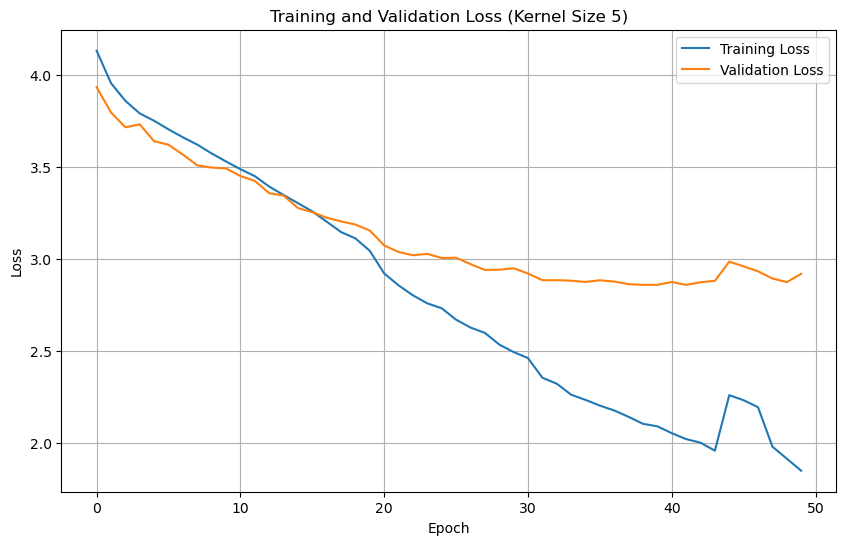

In [12]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(results[KERNEL_SIZE]['train_loss'], label='Training Loss')
plt.plot(results[KERNEL_SIZE]['val_loss'], label='Validation Loss')
plt.title(f'Training and Validation Loss (Kernel Size {KERNEL_SIZE})')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

#### Save the model results and training history for visualization.ipynb

In [10]:
import json

model = CatBreedCNN(kernel_size=KERNEL_SIZE)

# save model state
torch.save(model.state_dict(), 'cat_breed_cnn.pth')

# save history as JSON
with open('training_history.json', 'w') as f:
    json.dump(results[KERNEL_SIZE], f)

print("Model and history saved successfully.")

Model and history saved successfully.
